# **Step 1: Positional Encoding**

In [4]:
import tensorflow as tf
import numpy as np

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        self.pos_encoding = self.positional_encoding(max_seq_len, d_model)

    def get_angles(self, pos, i, d_model):
        angles = pos / np.power(10000, (2 * (i/2)) / np.float32(d_model))
        return angles

    def positional_encoding(self, max_seq_len, d_model):
        angle_rads = self.get_angles(
            np.arange(max_seq_len)[:, np.newaxis],
            np.arange(d_model)[np.newaxis, :],
            d_model
        )

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


# **Step 2: Token Embedding + Positional Encoding**

In [5]:
class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self,vocab_size,d_model,max_seq_len):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size,d_model)
        self.pos_encoding = PositionalEncoding(max_seq_len, d_model)
        self.d_model = d_model

    def call(self,x):
        #Scaling Embeddings by SQRT(d_model)
        x = self.embedding(x) 
        x *= tf.math.sqrt(tf.cast(self.d_model,tf.float32))

        #Adding Positional Encoding
        x = self.pos_encoding(x) 

        return x

        
        

# **Step 3A: Scaled Dot Product Attention**


In [6]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def call(self, q, k, v, mask=None):
        #Compute similarity scores
        matmul_qk = tf.matmul(q,k,transpose_b = True)

        #Scale by SQRT
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention = matmul_qk / tf.math.sqrt(dk)

        #Optional Mask
        if mask is not None:
            scaled_attention += (mask * -1e9)

        #Computing Attention weights
        attention_weights = tf.nn.softmax(scaled_attention, axis = -1)

        #Weighted sum of values
        output = tf.matmul(attention_weights, v)

        return output, attention_weights

# **Step 3B: Multi-Head Self Attention(MHA)**

In [7]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        #Splitting last dim into (num_heads, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        #Transopose for attention (batch, heads, seq_len, depth)
        return tf.transpose(x, perm=[0,2,1,3])

    def call(self,v,k,q,mask= None):
        batch_size = tf.shape(q)[0]

        #1. Linear Projections
        q = self.wq(q)   #batch, seq_len, d_model
        k = self.wk(k)
        v = self.wv(v)

        #2. Split into heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        #3. Applying scaled dot product attention
        scaled_attention, attention_weights = ScaledDotProductAttention()(q,k,v,mask)

        #4. Combining Heads: Transpose + Reshape
        scaled_attention = tf.transpose(scaled_attention,perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.num_heads * self.depth))

        #5. Final Linear Layer
        output = self.dense(concat_attention)
        return output, attention_weights

In [9]:
### TEST

mha1 = MultiHeadAttention(d_model=512, num_heads=8)
sample_input = tf.random.uniform((2, 5, 512))  # (batch=2, seq_len=5, d_model=512)
output, attn = mha1(sample_input, sample_input, sample_input)

print(output.shape)  # (2, 5, 512)
print(attn.shape)    # (2, 8, 5, 5)


(2, 5, 512)
(2, 8, 5, 5)


# **Step 3C: Feed Forward Network (FFN)**

FFN(x) = ReLU(xW1 + b1) W2 + b2

In [10]:
def point_wise_ffn(d_model,dff):  #what is dff?
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation = "relu"),
        tf.keras.layers.Dense(d_model)
    ])

# 
**Step 4A: Encoder Layer Implementation**

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,rate=0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model,num_heads)
        self.ffn = point_wise_ffn(d_model,dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False,mask=None):
        #Multi-Head Attention
        attn_out, attn_weights = self.mha(x,x,x,mask) #Self attention
        attn_out = self.dropout1(attn_out, training = training)

        #Residual Connection + LayerNorm
        out1 = self.layernorm1(x + attn_out)

        ##Feed Forward Network (FFN)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out, training = training)

        #Residual Connection + LayerNorm
        out2 = self.layernorm2(out1 + ffn_out)


        return out2, attn_weights

In [12]:
### TEST

sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)
sample_input = tf.random.uniform((2, 5, 512))  # (batch=2, seq_len=5)

output, attn_weights = sample_encoder_layer(sample_input, training=False)

print(output.shape)        # (2, 5, 512)
print(attn_weights.shape)  # (2, 8, 5, 5)


(2, 5, 512)
(2, 8, 5, 5)


# **Step 4B: Full Encoder** 

In [13]:
def positional_encoding(max_seq_len, d_model):
    pos = np.arange(max_seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]

    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    angles = pos * angle_rates

    angles[:, 0::2] = np.sin(angles[:, 0::2])
    angles[:, 1::2] = np.cos(angles[:, 1::2])

    pos_encoding = angles[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


class FullEncoder(tf.keras.layers.Layer):
    def __init__(self,num_layers, d_model, num_heads,dff,
               vocab_size,max_seq_len,rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        #Embedding Layers
        self.embedding = tf.keras.layers.Embedding(vocab_size,d_model)
        self.pos_encoding = positional_encoding(max_seq_len, d_model)


        self.enc_layers = [
            EncoderLayer(d_model,num_heads,dff,rate)
            for _ in range(num_layers)
        ]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]

        #Token Embedding + Scaling + Positional Encoding
        x = self.embedding(x)  # (batch, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        #Passing through N encoder layers
        for i in range(self.num_layers):
            x, attn_weights = self.enc_layers[i](x, training=training, mask=mask)

        return x, attn_weights  # last attention weights for visualization

In [14]:
### TEST

sample_encoder = FullEncoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, vocab_size=8500, max_seq_len=100)

sample_input = tf.constant([[1,2,3,4,0],[5,6,7,0,0]])  # (batch=2, seq_len=5)

sample_output, attn_weights = sample_encoder(sample_input, training=False)

print(sample_output.shape)  # (2, 5, 512)
print(attn_weights.shape)   # (2, 8, 5, 5)


(2, 5, 512)
(2, 8, 5, 5)


# **Step 5: Decoder Layer Implementation**

In [15]:
# Masking Function
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)

In [16]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads,dff,rate = 0.1):
        super().__init__()

        #Masked MHA
        self.mha2 = MultiHeadAttention(d_model,num_heads)

        #Encoder-Decoder MHA
        self.mha3 = MultiHeadAttention(d_model,num_heads)

        #Feed Forward Network
        self.ffn = self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'), 
            tf.keras.layers.Dense(d_model)                 
        ])

        #LayerNormalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)


        #Dropout Layer
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask = None, padding_mask= None):

        #Masked Self Attention
        attn1, attn_weights_block1 = self.mha2(x,x,x,mask = look_ahead_mask)
        attn1 = self.dropout1(attn1,training=training)
        out1 = self.layernorm1(x + attn1)

        # Encoder-Decoder attention
        attn2, attn_weights_block2 = self.mha3(
            enc_output, enc_output, out1, mask=padding_mask
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)  # residual
        
        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)  # residual
        
        return out3, attn_weights_block1, attn_weights_block2

In [17]:
### TEST

sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_x = tf.random.uniform((2, 5, 512))       # target seq
sample_enc_output = tf.random.uniform((2, 6, 512))  # encoder seq

out, attn1, attn2 = sample_decoder_layer(
    sample_x, sample_enc_output, training=False, 
    look_ahead_mask=None, padding_mask=None
)

print(out.shape)    # (2, 5, 512)
print(attn1.shape)  # (2, 8, 5, 5) -> masked self-attention
print(attn2.shape)  # (2, 8, 5, 6) -> encoder-decoder attention


(2, 5, 512)
(2, 8, 5, 5)
(2, 8, 5, 6)


# **Step 5B: Full Decoder** 

In [18]:
class FullDecoder(tf.keras.layers.Layer):
    def __init__(self,num_layers,d_model,num_heads,dff,
                target_vocab_size,max_seq_len,rate = 0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers =num_layers

        #Token Embedding + Positional Encoding
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_seq_len, d_model)

        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self,x,enc_output,training,look_ahead_mask = None, padding_mask = None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        #Token emb + Scaling + Pos Enc
        x = self.embeddong = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training = training)

        # Stack Decoder layer
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x, enc_output, 
                training = training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # where x : batch, target_seq_len, d_model
        return x, attention_weights



In [19]:
### TEST

sample_decoder = FullDecoder(num_layers=2, d_model=512, num_heads=8, dff=2048,
                         target_vocab_size=8000, max_seq_len=50)

sample_target = tf.constant([[1,2,3,4,0],[5,6,7,0,0]])  # (batch=2, seq_len=5)
sample_enc_output = tf.random.uniform((2, 6, 512))

out, attn = sample_decoder(
    sample_target, sample_enc_output,
    training=False,
    look_ahead_mask=None,
    padding_mask=None
)

print(out.shape)  # (2, 5, 512)
for k,v in attn.items():
    print(k, v.shape)


(2, 5, 512)
decoder_layer1_block1 (2, 8, 5, 5)
decoder_layer1_block2 (2, 8, 5, 6)
decoder_layer2_block1 (2, 8, 5, 5)
decoder_layer2_block2 (2, 8, 5, 6)


**Encoder encodes the source sequence**

**Decoder autoregressively predicts target sequence tokens**

**Final Dense projects to vocabulary size for prediction**

# **Final Step: Full Transfromer**

In [20]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers,d_model,num_heads,dff,
                input_vocab_size,target_vocab_size,
                pe_input,pe_target,rate=0.1):
        super().__init__()

        # Encoder & Decoder
        self.encoder = FullEncoder(
            num_layers,d_model,num_heads,dff,
            vocab_size=input_vocab_size,
            max_seq_len = pe_input,
            rate=rate
        )

        self.decoder = FullDecoder(
            num_layers, d_model, num_heads, dff,
            target_vocab_size = target_vocab_size,
            max_seq_len= pe_target,
            rate=rate
        )

        #Final Linear Projection
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self,inp,tar,training,
            enc_padding_mask=None,
            look_ahead_mask=None,
            dec_padding_mask=None):

        #Encoder
        enc_output, _ = self.encoder(inp,training=training,mask=enc_padding_mask)

        #Decoder
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training=training,
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )


        #dec_output: (batch, tar_seq_len, d_model)


        #Final Dense Layer
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [21]:
### TEST

sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=1000, pe_target=1000
)

sample_inp = tf.random.uniform((2, 6), dtype=tf.int64, minval=0, maxval=200)
sample_tar = tf.random.uniform((2, 5), dtype=tf.int64, minval=0, maxval=200)

final_output, attn = sample_transformer(
    sample_inp, sample_tar, training=False,
    enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None
)

print(final_output.shape)  # (2, 5, 8000)
for k, v in attn.items():
    print(k, v.shape)


(2, 5, 8000)
decoder_layer1_block1 (2, 8, 5, 5)
decoder_layer1_block2 (2, 8, 5, 6)
decoder_layer2_block1 (2, 8, 5, 5)
decoder_layer2_block2 (2, 8, 5, 6)


# Visualization of Weights

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_weights(attention, sentence, layer_name):
    """
    attention: shape (num_heads, seq_len_q, seq_len_k)
    sentence: list of tokens (for x/y labels)
    layer_name: str, label for plot
    """
    num_heads = attention.shape[0]
    fig, axes = plt.subplots(1, num_heads, figsize=(30, 10))
    plt.title("Heatmap of attention weights")
    
    if num_heads == 1:
        axes = [axes]  # make it iterable

    for head in range(num_heads):
        ax = axes[head]
        sns.heatmap(attention[head], xticklabels=sentence, yticklabels=sentence,
                    cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{layer_name} - Head {head+1}')

    plt.show()


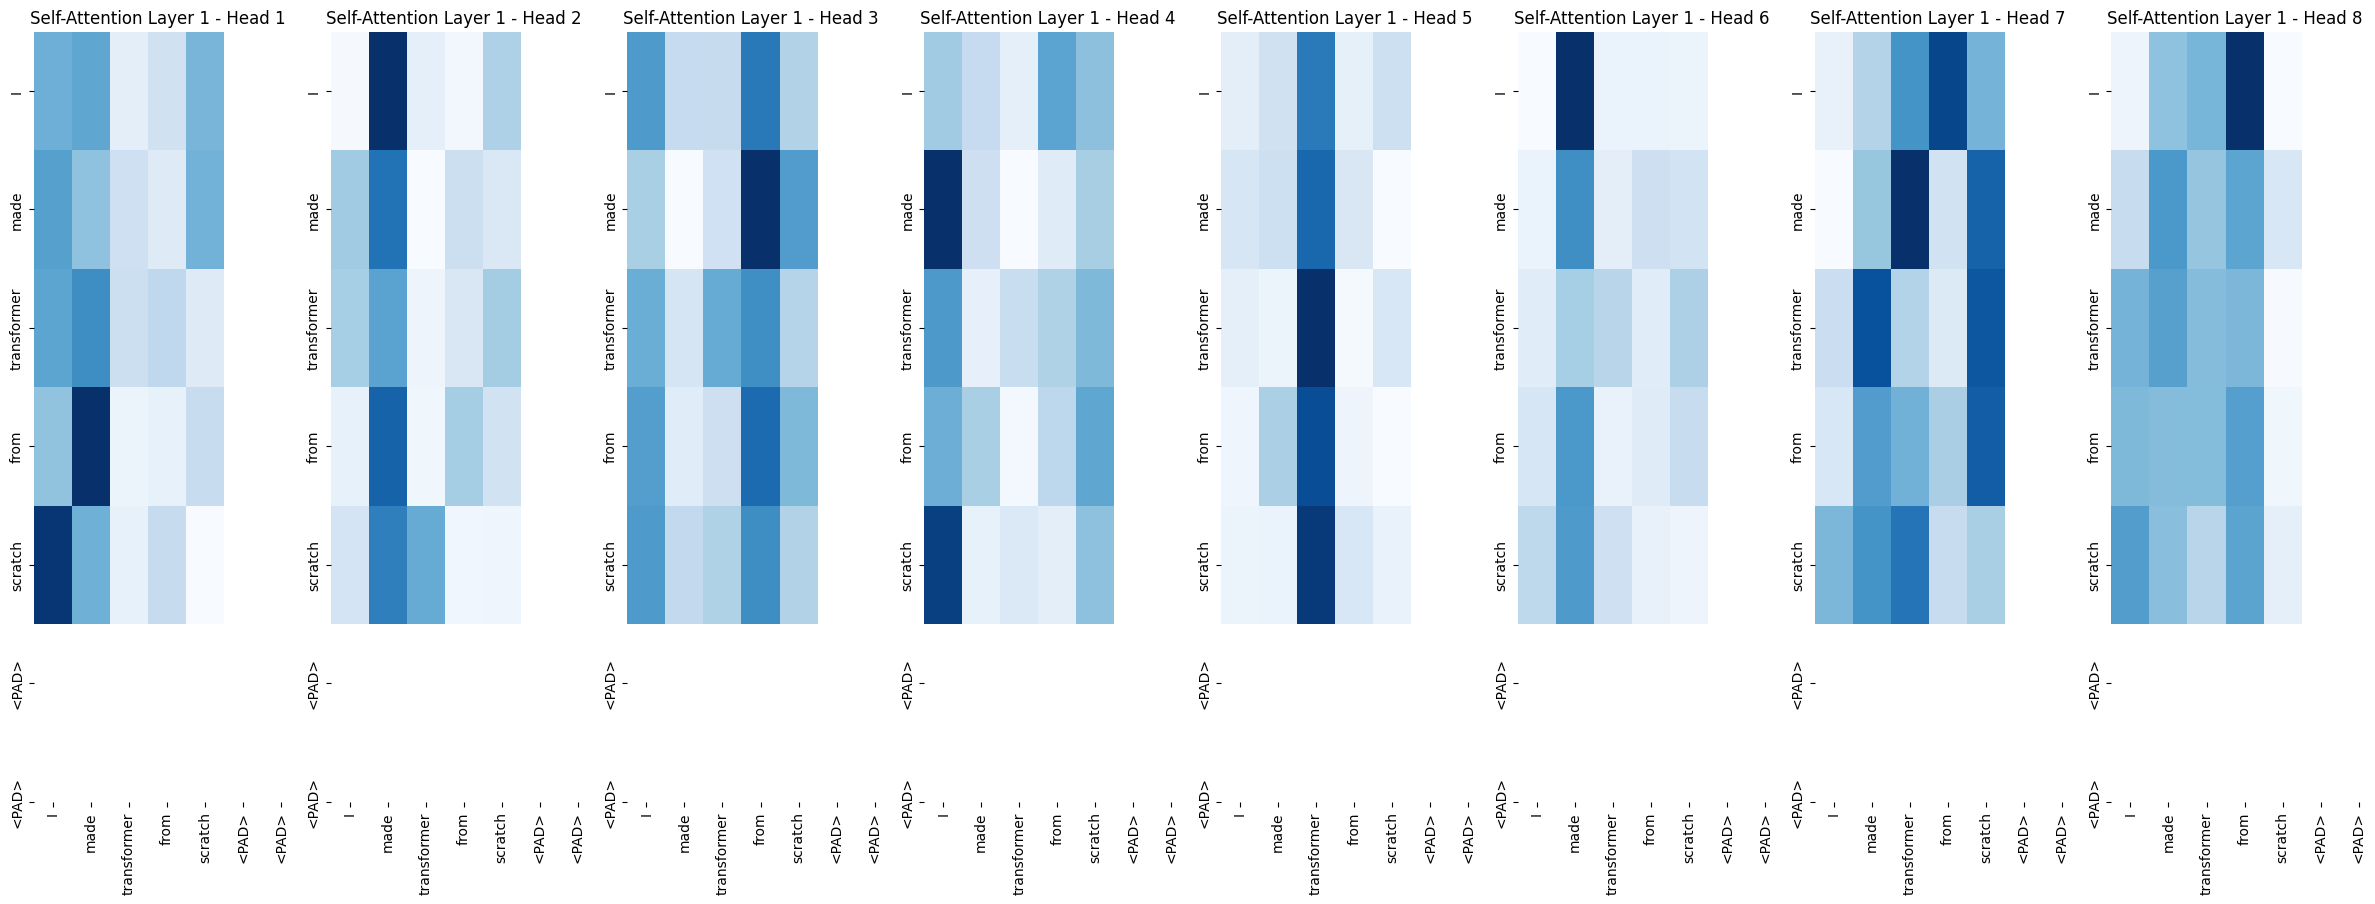

In [30]:
sample_sentence = ["I", "made", "transformer","from","scratch", "<PAD>", "<PAD>"]

# Assume `attn_weights` came from your encoder
attn = attn_weights[0].numpy()  # (num_heads, seq_len_q, seq_len_k)

plot_attention_weights(attn, sample_sentence, "Self-Attention Layer 1")
